In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
import numpy.random as npr
npr.seed(1234)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_nichols_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalStationaryTransitions, HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions, \
    HierarchicalNeuralNetworkRecurrentTransitions, GroupRecurrentTransitions, ElaborateGroupRecurrentTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0    # dimensionality of input
results_dir = "results/nichols/2018-09-26/D{}".format(D)

In [3]:
groups = ["n2_1_prelet", 
          "n2_2_let",
          "npr1_1_prelet",
          "npr1_2_let"]

worms_and_groups = [(i, "n2_1_prelet") for i in range(11)] + \
                   [(i, "n2_2_let") for i in range(12)] + \
                   [(i, "npr1_1_prelet") for i in range(10)] + \
                   [(i, "npr1_2_let") for i in range(11)]
worm_names = ["{} worm {}".format(group, i) for (i, group) in worms_and_groups]

In [4]:
# Load the data
ys, ms, us, z_trues, z_true_key, neuron_names = load_nichols_data(worms_and_groups, worm_names, include_unnamed=False, signal="dff")

Only including named neurons.
73 neurons across all 44 worms


In [5]:
ys = [trend_filter(y) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]
K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

In [6]:
for cname, zname in zip(zplt.color_names, z_true_key):
    print(cname, ":", zname )

windows blue : Quiescence
red : Forward
amber : Reversal
faded green : Ventral turn
dusty purple : Dorsal turn
orange : undefined turn


In [7]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
_pca = cached(results_dir, "pca")(pca_with_imputation)
pca, xs = _pca(D, ys, ms, num_iters=100)

/home/scott/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Split into train/test/validation

In [8]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_xs = []
all_ms = []
all_us = []
all_gs = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, x, m, u, tag, ztr) in enumerate(zip(ys, xs, ms, us, worms_and_groups, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_xs.append(x[start:stop])
        all_ms.append(m[start:stop])
        all_us.append(u[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_xs = get(all_xs, 0)
train_ms = get(all_ms, 0)
train_us = get(all_us, 0)
train_zs = get(all_z_trues, 0)
# train_tags = get(all_gs, 0)
train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_xs = get(all_xs, 1)
val_ms = get(all_ms, 1)
val_us = get(all_us, 1)
val_zs = get(all_z_trues, 1)
# val_tags = get(all_gs, 1)
val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_xs = get(all_xs, 2)
test_ms = get(all_ms, 2)
test_us = get(all_us, 2)
test_zs = get(all_z_trues, 2)
# test_tags = get(all_gs, 2)
test_tags = get(all_tags, 2)

In [9]:
# Compute number of training, validation, and test entries
D_train = sum([x.size for x in train_xs])
D_val = sum([x.size for x in val_xs])
D_test = sum([x.size for x in test_xs])

print("D_train: ", D_train)
print("D_val:   ", D_val)
print("D_test:  ", D_test)

D_train:  986680
D_val:    219100
D_test:   219340


# Fit an ARHMM to the continuous latent states, sweeping over number of discrete latent states

In [10]:
Ks = np.arange(2, 21, step=2)
etas = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
transitionss = ["recurrent"]
observationss = ["robust_ar"]

In [11]:
def _fit_hmm(K, transitions, observations):
    hmm = HMM(K, D, M, transitions=transitions, observations=observations)
    lps = hmm.fit(train_xs, method="em", num_em_iters=250)
    val_ll = hmm.log_likelihood(val_xs)
    return hmm, lps, val_ll

In [12]:
hmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hmm_results_name)(_fit_hmm)
            
            print("Fitting ", hmm_results_name)
            hmm_results[hmm_results_name] = fit(K, transitions, observations)
            
with open(os.path.join(results_dir, "hmm_results.pkl"), "wb") as f:
    pickle.dump(hmm_results, f)

Fitting  hmm_recurrent_robust_ar_K2
Fitting  hmm_recurrent_robust_ar_K4
Fitting  hmm_recurrent_robust_ar_K6
Fitting  hmm_recurrent_robust_ar_K8
Fitting  hmm_recurrent_robust_ar_K10
Fitting  hmm_recurrent_robust_ar_K12
Fitting  hmm_recurrent_robust_ar_K14
Fitting  hmm_recurrent_robust_ar_K16
Fitting  hmm_recurrent_robust_ar_K18
Fitting  hmm_recurrent_robust_ar_K20


/home/scott/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Fit hierarchical HMMs

In [13]:
def _fit_hierarchical_hmm(K, eta, transitions, observations, hmm):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, M)

    transition_classes = dict(recurrent=ElaborateGroupRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, worms_and_groups, M, eta1=eta, eta2=1e-1)
    assert transition_distn.T == len(worms_and_groups)
    assert transition_distn.G == 4
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               independent_ar=HierarchicalIndependentAutoRegressiveObservations,
                               robust_ar=HierarchicalRobustAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, worms_and_groups, M, eta=eta)
    
    # Construct the HMM
    hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    hhmm.transitions.initialize_from_standard(hmm.transitions)
    hhmm.observations.initialize_from_standard(hmm.observations)

    # Fit
    lps = hhmm.fit(train_xs, tags=train_tags, method="em", num_em_iters=250, initialize=False)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, tags=val_tags)
    return hhmm, lps, val_ll

In [14]:
hhmm_results = {}
for K in Ks:
    for eta in etas:
        for transitions in transitionss:
            for observations in observationss:
                # Get the HMM results
                hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
                hmm, _, _ = hmm_results[hmm_results_name]

                # Fit the Hierarchical HMM
                hhmm_results_name = "hhmm_{}_{}_K{}_eta{:1.0e}".format(transitions, observations, K, eta)
                fit = cached(results_dir, hhmm_results_name)(_fit_hierarchical_hmm)
                print("Fitting ", hhmm_results_name)
                hhmm_results[hhmm_results_name] = fit(K, eta, transitions, observations, hmm)
            
with open(os.path.join(results_dir, "hhmm_results.pkl"), "wb") as f:
    pickle.dump(hhmm_results, f)

Fitting  hhmm_recurrent_robust_ar_K2_eta1e+00
Fitting  hhmm_recurrent_robust_ar_K2_eta1e-01
Fitting  hhmm_recurrent_robust_ar_K2_eta1e-02
Fitting  hhmm_recurrent_robust_ar_K2_eta1e-03
Fitting  hhmm_recurrent_robust_ar_K2_eta1e-04
Fitting  hhmm_recurrent_robust_ar_K4_eta1e+00
Fitting  hhmm_recurrent_robust_ar_K4_eta1e-01
Fitting  hhmm_recurrent_robust_ar_K4_eta1e-02
Fitting  hhmm_recurrent_robust_ar_K4_eta1e-03
Fitting  hhmm_recurrent_robust_ar_K4_eta1e-04
Fitting  hhmm_recurrent_robust_ar_K6_eta1e+00
Fitting  hhmm_recurrent_robust_ar_K6_eta1e-01
Fitting  hhmm_recurrent_robust_ar_K6_eta1e-02
Fitting  hhmm_recurrent_robust_ar_K6_eta1e-03
Fitting  hhmm_recurrent_robust_ar_K6_eta1e-04
Fitting  hhmm_recurrent_robust_ar_K8_eta1e+00
Fitting  hhmm_recurrent_robust_ar_K8_eta1e-01
Fitting  hhmm_recurrent_robust_ar_K8_eta1e-02
Fitting  hhmm_recurrent_robust_ar_K8_eta1e-03
Fitting  hhmm_recurrent_robust_ar_K8_eta1e-04
Fitting  hhmm_recurrent_robust_ar_K10_eta1e+00
Fitting  hhmm_recurrent_robust_ar

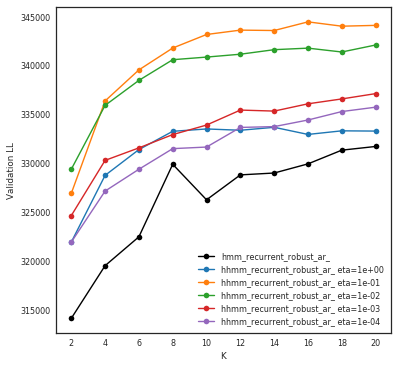

In [15]:
# Plot train and validation likelihoods

# num_bars = len(transitions) * len(observations)

plt.figure(figsize=(6, 6))
for transitions in transitionss:
    for observations in observationss:
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hmm_val_lls, '-ko', label=hmm_results_prefix)

        for eta in etas:
            hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
            hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}_eta{:1.0e}".format(K, eta)][2] for K in Ks]
            plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix + " eta={:1.0e}".format(eta))

plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("Validation LL")
plt.legend()

# Fit the HHMM to the full train and validation data

In [16]:
best_K = 12
best_eta = 1e-1

In [17]:
def _fit_to_all_data(model):
    lps = model.fit(train_xs + val_xs, tags=train_tags + val_tags, method="em", num_em_iters=100, initialize=False)
    return model, lps

In [18]:
# Fit the HMMs
best_results = {}

# for transitions in transitionss:
#     for observations in observationss:
#         hmm_results_prefix = "hmm_{}_{}".format(transitions, observations)
#         hmm_val_lls = [hmm_results[hmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
#         best_K = Ks[np.argmax(hmm_val_lls)]
        
#         # Fit the best model    
#         results_name = "best_" + hmm_results_prefix
#         print("Fitting ", results_name, " with K = ", best_K)
#         fit = cached(results_dir, results_name)(_fit_to_all_data)
#         hmm, _ = fit(hmm_results[hmm_results_prefix + "_K{}".format(best_K)][0])
        
#         # Compute the log likelihood of the test data
#         test_ll = hmm.log_likelihood(test_xs, tags=test_tags)
#         best_results[results_name] = (hmm, test_ll)
        
# Fit the HHMMs
for transitions in transitionss:
    for observations in observationss:
        hhmm_results_prefix = "hhmm_{}_{}".format(transitions, observations)
        # hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "_K{}_eta{:1.0e}".format(K, best_eta)][2] for K in Ks]
        # best_K = Ks[np.argmax(hhmm_val_lls)]
        
        # Fit the best model    
        results_name = "best_" + hhmm_results_prefix
        print("Fitting ", results_name, " with K = ", best_K)
        fit = cached(results_dir, results_name)(_fit_to_all_data)
        hhmm, _ = fit(hhmm_results[hhmm_results_prefix + "_K{}_eta{:1.0e}".format(best_K, best_eta)][0])
        
        # Compute the log likelihood of the test data
        test_ll = hhmm.log_likelihood(test_xs, tags=test_tags)
        best_results[results_name] = (hhmm, test_ll)
        
with open(os.path.join(results_dir, "best_results.pkl"), "wb") as f:
    pickle.dump(best_results, f)

Fitting  best_hhmm_recurrent_robust_ar  with K =  12


# Evaluate model fit

In [19]:
hhmm, _ = best_results["best_hhmm_recurrent_robust_ar"]

In [20]:
# Get the inferred states
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in zip(worms_and_groups, xs)]
hhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in zip(worms_and_groups, xs)]

In [21]:
# plt.figure(figsize=(12, 16))
# lim = 6
# w_to_plot=(0, 11, 23, 33)
# for i,w in enumerate(w_to_plot):
#     x = xs[w]
#     z= z_infs[w]
#     for d in range(1, 4):
#         ax = plt.subplot(4, 4, (d-1) * 4 + i+1)
#         zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
#         plt.ylabel("PC {}".format(d+1) if i == 0 else "")
#         plt.title(worm_names[w])

# plt.suptitle("Continuous Latent States (Inferred Labels)")
# plt.tight_layout()

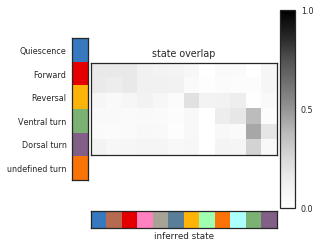

In [22]:
# Compute the overlap between inferred and true states
K_zimmer = len(z_true_key)
overlap = np.zeros((K_zimmer, hhmm.K), dtype=float)
for ww in range(W):
    for k1 in range(K_zimmer):
        for k2 in range(hhmm.K):
            overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

# Normalize the overlap from all worms and plot
overlap /= overlap.sum(1)[:, None]

# Permute to make blocky as possible
most_overlap = np.argmax(overlap, axis=0)
perm_overlap = np.argsort(most_overlap)

fig = plt.figure(figsize=(4, 4))
gs = GridSpec(11, 12)

ax1 = fig.add_subplot(gs[:10, 1:11])
im = ax1.imshow(overlap[:, perm_overlap], vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title("state overlap")

lax = fig.add_subplot(gs[:10, 0])
lax.imshow(np.arange(K_zimmer)[:, None], cmap=zplt.default_cmap, 
              vmin=0, vmax=len(zplt.default_colors) - 1, aspect=1.5)

lax.set_xticks([])
lax.set_yticks(np.arange(K_zimmer))
lax.set_yticklabels(z_true_key)

bax = fig.add_subplot(gs[10, 1:11])
bax.imshow(np.arange(hhmm.K)[None, perm_overlap], cmap=zplt.default_cmap,  aspect="auto",
           vmin=0, vmax=len(zplt.default_colors)-1)
bax.set_xticks([])
bax.set_yticks([])
bax.set_xlabel("inferred state")

axcb = fig.add_subplot(gs[:10, 11])
plt.colorbar(im, cax=axcb, ticks=[0, 0.5, 1])


# Simulate from the model

In [23]:
def simulate_model(name, model, pad=3, N_smpls=20):
    # Get the inferred states
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in zip(worms_and_groups, xs)]
    model.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in zip(worms_and_groups, xs)]
    
    # Lower the noise
    model_low_noise = copy.deepcopy(model)
    model_low_noise.observations.inv_sigmas -= 4
    
    simulations = []

    for g in range(4):
        # Simulate N_smpls for this worm
        model_simulations_g = []
        for s in range(N_smpls):
            print("Model ", name, " Group ", g, " sample ", s)
            # Sample data
            Tsmpl = Ts[g*12]
            zpre, xpre = z_infs[g*12][-pad:], xs[g*12][-pad:]
            zsmpl, xsmpl = model_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=(0, groups[g]), with_noise=True)

            zsmpl = np.concatenate((zpre, zsmpl))
            xsmpl = np.concatenate((xpre, xsmpl))

            # Truncate to stable region
            unstable = np.arange(Tsmpl+pad)[np.any(abs(xsmpl) > 10, axis=1)]
            T_stable = np.min(np.concatenate(([Tsmpl+pad], unstable)))
            zsmpl = zsmpl[:T_stable]
            xsmpl = xsmpl[:T_stable]

            # Project into neural space
            ysmpl = xsmpl.dot(pca.components_) + pca.mean_

            # Append
            model_simulations_g.append((zsmpl, xsmpl, ysmpl))
            
        # Append this worm
        simulations.append(model_simulations_g)
        
    return simulations

In [24]:
simulations = {}
for name, (model, _) in best_results.items(): 
    print("Simulating ", name)
    _sim = cached(results_dir, name + "_sim")(simulate_model)
    simulations[name] = _sim(name, model)

Simulating  best_hhmm_recurrent_robust_ar


In [25]:
# for g in range(4):
#     plt.figure()
#     ax = plt.subplot(111)
#     for z, x, y in simulations["best_hhmm_recurrent_robust_ar"][g][:2]:
#         zplt.plot_2d_continuous_states(x, z, ax=ax, xlims=(-6, 6), ylims=(-6, 6))
# #         plt.plot(x[:,0], x[:,1], color='k', alpha=0.5)

# Fit a model with inputs

(2000, 2200)

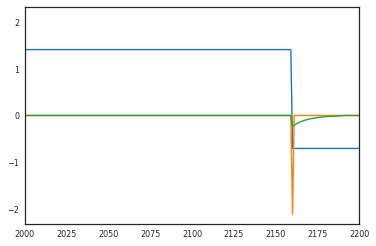

In [26]:
o2 = (us[0] - 13.6678) / 5.185
do2 = np.concatenate(([0], np.diff(o2)))

f = np.exp(-np.arange(3 * 10) / (3 * 3))
f /= f.sum()
f_do2 = np.convolve(do2, f, mode="full")[:-len(f)]

    
plt.plot(o2)
plt.plot(do2)
plt.plot(f_do2)
# plt.xlim(1000, 1200)
plt.xlim(2000, 2200)

In [27]:
do2.max(), do2.min()

(2.1215043394406945, -2.1215043394406945)

In [28]:
# Convert u into o2 and do2s
# E[u] = 13.6678;  std[u] = 5.185
def u_to_features(u, nlags=9):
    o2 = (u - 13.6678) / 5.185
    do2 = np.concatenate(([0], np.diff(o2)))
    
    # Also add the smoothed do2
    f = np.exp(-np.arange(3 * 10) / (3 * 3))
    f /= f.sum()
    f_do2 = np.convolve(do2, f, mode="full")[:-len(f)+1]
    
    features = [o2, f_do2]
    return np.column_stack(features)

train_inputs = [u_to_features(u) for u in train_us]
val_inputs = [u_to_features(u) for u in val_us]
test_inputs = [u_to_features(u) for u in test_us]
M = test_inputs[0].shape[1]

In [29]:
def _fit_hierarchical_hmm_with_inputs(M, K, transitions, observations, hmm):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, 0)

    transition_classes = dict(recurrent=ElaborateGroupRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, worms_and_groups, 0, eta1=best_eta, eta2=1e-1)
    assert transition_distn.T == len(worms_and_groups)
    assert transition_distn.G == 4
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               independent_ar=HierarchicalIndependentAutoRegressiveObservations,
                               robust_ar=HierarchicalRobustAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, worms_and_groups, 0, eta=best_eta)
    
    # Construct the HMM
    hhmm = _HMM(K, D, 0, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    hhmm.transitions.initialize_from_standard(hmm.transitions)
    hhmm.observations.initialize_from_standard(hmm.observations)

    # Override M and set the input parameters
    Gt, Go = hhmm.transitions.G, hhmm.observations.G
    hhmm.M = M

    hhmm.transitions.M = M
    hhmm.transitions.eta2 = 1
    hhmm.transitions.shared_Ws = np.zeros((K, M))
    hhmm.transitions.Ws = np.zeros((Gt, K, M))
    
    hhmm.observations.M = M
    hhmm.observations.shared_Vs = np.zeros((K, D, M))
    hhmm.observations.Vs = np.zeros((Go, K, D, M))
    
    # Fit
    lps = hhmm.fit(train_xs, inputs=train_inputs, tags=train_tags, method="em", num_em_iters=250, initialize=False)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, inputs=val_inputs, tags=val_tags)
    return hhmm, lps, val_ll

In [30]:
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            # Get the results of the HHMM without inputs
            # base_results_name = "hhmm_{}_{}_K{}_eta{:1.0e}".format(transitions, observations, K, best_eta)
            # base, _, _ = hhmm_results[base_results_name]
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            hmm, _, _ = hmm_results[hmm_results_name]


            # Fit the HHMM with inputs
            hhmm_results_name = "hhmm_{}_{}_K{}_inputs".format(transitions, observations, K)
            fit = cached(results_dir, hhmm_results_name)(_fit_hierarchical_hmm_with_inputs)
            print("Fitting ", hhmm_results_name)
            hhmm_results[hhmm_results_name] = fit(M, K, transitions, observations, hmm)

with open(os.path.join(results_dir, "hhmm_results.pkl"), "wb") as f:
    pickle.dump(hhmm_results, f)

Fitting  hhmm_recurrent_robust_ar_K2_inputs
Fitting  hhmm_recurrent_robust_ar_K4_inputs
Fitting  hhmm_recurrent_robust_ar_K6_inputs
Fitting  hhmm_recurrent_robust_ar_K8_inputs
Fitting  hhmm_recurrent_robust_ar_K10_inputs
Fitting  hhmm_recurrent_robust_ar_K12_inputs
Fitting  hhmm_recurrent_robust_ar_K14_inputs
Fitting  hhmm_recurrent_robust_ar_K16_inputs
Fitting  hhmm_recurrent_robust_ar_K18_inputs
Fitting  hhmm_recurrent_robust_ar_K20_inputs


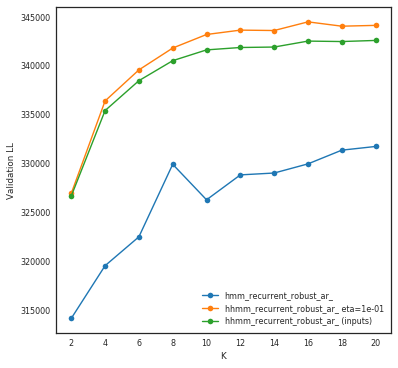

In [31]:
plt.figure(figsize=(6, 6))
for transitions in transitionss:
    for observations in observationss:
        # HMM
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hmm_val_lls, '-o', label=hmm_results_prefix)

        # HHMM
        for eta in [1e-1]:
            hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
            hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}_eta{:1.0e}".format(K, eta)][2] for K in Ks]
            plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix + " eta={:1.0e}".format(eta))
            
        # HHMM with inputs
        hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
        hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}_inputs".format(K)][2] for K in Ks]
        plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix + " (inputs)")

plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("Validation LL")
plt.legend()

In [32]:
irhhmm = hhmm_results["hhmm_recurrent_robust_ar_K12_inputs"][0]
irhhmm.observations.eta

0.1

# Plot some segmentations

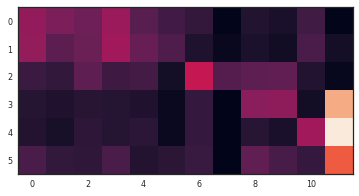

In [61]:
# Get the inferred states
z_infs = [irhhmm.most_likely_states(x, tag=g) for g, x in zip(worms_and_groups, xs)]
# irhhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))

# Permute the states based on the overlap with the manually labeled states
K_zimmer = len(z_true_key)
overlap = np.zeros((K_zimmer, irhhmm.K), dtype=float)
for ww in range(W):
    for k1 in range(K_zimmer):
        for k2 in range(irhhmm.K):
            overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

overlap /= overlap.sum(axis=1, keepdims=True)
best_match = np.argmax(overlap, axis=0)
perm = np.argsort(best_match)
irhhmm.permute(perm)

new_colors = [zplt.default_colors[best_match[k]] for k in perm]
new_colors = np.array(new_colors)
new_colors = np.column_stack((new_colors, np.ones(irhhmm.K)))
for k in range(1, irhhmm.K):
    if best_match[perm][k] == best_match[perm][k-1]:
        new_colors[k][3] = new_colors[k-1][3] * .8
from hips.plotting.colormaps import gradient_cmap
new_cmap = gradient_cmap(new_colors)

plt.imshow(overlap[:, perm])

z_infs = [irhhmm.most_likely_states(x, tag=g) for g, x in zip(worms_and_groups, xs)]

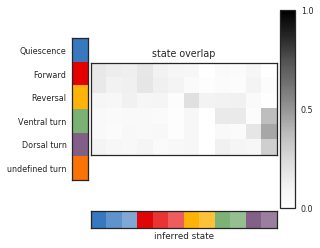

In [62]:
# Compute the overlap between inferred and true states
K_zimmer = len(z_true_key)
overlap = np.zeros((K_zimmer, irhhmm.K), dtype=float)
for ww in range(W):
    for k1 in range(K_zimmer):
        for k2 in range(irhhmm.K):
            overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

# Normalize the overlap from all worms and plot
overlap /= overlap.sum(1)[:, None]

# Permute to make blocky as possible
# most_overlap = np.argmax(overlap, axis=0)
# perm_overlap = np.argsort(most_overlap)
perm_overlap = np.arange(irhhmm.K)

fig = plt.figure(figsize=(4, 4))
gs = GridSpec(11, 12)

ax1 = fig.add_subplot(gs[:10, 1:11])
im = ax1.imshow(overlap[:, perm_overlap], vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title("state overlap")

lax = fig.add_subplot(gs[:10, 0])
lax.imshow(np.arange(K_zimmer)[:, None], cmap=zplt.default_cmap, 
              vmin=0, vmax=len(zplt.default_colors) - 1, aspect=1.5)

lax.set_xticks([])
lax.set_yticks(np.arange(K_zimmer))
lax.set_yticklabels(z_true_key)

bax = fig.add_subplot(gs[10, 1:11])
bax.imshow(np.arange(irhhmm.K)[None, perm_overlap], cmap=new_cmap,  aspect="auto",
           vmin=0, vmax=irhhmm.K-1)
bax.set_xticks([])
bax.set_yticks([])
bax.set_xlabel("inferred state")

axcb = fig.add_subplot(gs[:10, 11])
plt.colorbar(im, cax=axcb, ticks=[0, 0.5, 1])


Text(0.5,0,'inferred state')

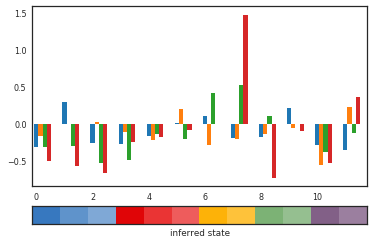

In [64]:
o2_effect = irhhmm.transitions.Ws[:, :, 0] * (1.4141176470588237 - -0.7073866923818708)

plt.figure()
gs = GridSpec(2, 1, height_ratios=[10, 1])
ax = plt.subplot(gs[0, 0])
for g in range(4):
    plt.bar(np.arange(irhhmm.K) + .15 * g, o2_effect[g], width=0.15)
plt.xlim(-.15, irhhmm.K-1.5*.15)
bax = plt.subplot(gs[1, 0])
bax.imshow(np.arange(irhhmm.K)[None, perm_overlap], cmap=new_cmap,  aspect="auto", vmin=0, vmax=irhhmm.K-1)
bax.set_xticks([])
bax.set_yticks([])
bax.set_xlabel("inferred state")

Text(0.5,0,'inferred state')

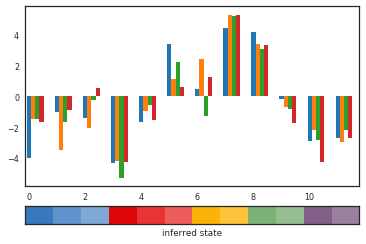

In [65]:
do2_on_effect = irhhmm.transitions.Ws[:, :, 1] * (2.1215043394406945)

plt.figure()
gs = GridSpec(2, 1, height_ratios=[10, 1])
ax = plt.subplot(gs[0, 0])
for g in range(4):
    plt.bar(np.arange(irhhmm.K) + .15 * g, do2_on_effect[g], width=0.15)
plt.xlim(-.15, irhhmm.K-1.5*.15)
bax = plt.subplot(gs[1, 0])
bax.imshow(np.arange(irhhmm.K)[None, perm_overlap], cmap=new_cmap,  aspect="auto", vmin=0, vmax=irhhmm.K-1)
bax.set_xticks([])
bax.set_yticks([])
bax.set_xlabel("inferred state")

In [66]:
# Make a mountain plot of state usage
usage = np.zeros((len(groups), np.max(Ts), best_K))
for g, group in enumerate(groups):
    for w, (_, gg) in enumerate(worms_and_groups):
        if gg != group:
            continue
        
        zw = z_infs[w]
        Tw = Ts[w]
        usage[g * np.ones(Tw, dtype=int), np.arange(Tw), zw.astype(int)] += 1
        
avg_usage = usage / usage.sum(axis=-1, keepdims=True)

from scipy.ndimage import gaussian_filter1d
smooth_avg_usage = gaussian_filter1d(avg_usage, 6, axis=1)

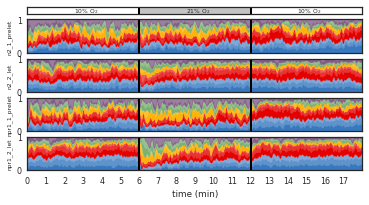

In [67]:
plt.figure(figsize=(6, 3))
gs = GridSpec(5, 1, height_ratios=[.2, 1, 1, 1, 1])

plt.subplot(gs[0, 0])
plt.imshow(us[0][None, :], aspect="auto", vmin=np.min(us[0]), vmax=2*np.max(us[0]), cmap="Greys")
plt.text(2.5 * 60 * 3, .3, "10% O$_2$", fontsize=6)
plt.text(8.5 * 60 * 3, .3, "21% O$_2$", fontsize=6)
plt.text(14.5 * 60 * 3, .3, "10% O$_2$", fontsize=6)
plt.plot([6 * 60 * 3, 6 * 60 * 3], [-.5, .5], '-k', lw=2)
plt.plot([12 * 60 * 3, 12 * 60 * 3], [-.5, .5], '-k', lw=2)
plt.xticks([])
plt.yticks([])

for g, group in enumerate(groups):
    plt.subplot(gs[g+1, 0])
    
    # Make mountain plot
    offset = np.zeros((np.max(Ts),))
    for k in range(best_K):
        plt.fill_between(np.arange(np.max(Ts)), offset, offset + smooth_avg_usage[g, :, k], color=new_colors[k])
        offset += smooth_avg_usage[g, :, k]
    
    # Plot dividers
    plt.plot([6 * 60 * 3, 6 * 60 * 3], [0, 1], '-k', lw=2)
    plt.plot([12 * 60 * 3, 12 * 60 * 3], [0, 1], '-k', lw=2)
    
    plt.xlim(0, np.max(Ts)+1)
    if g < 3:
        plt.xticks([])
    else:
        plt.xticks(np.arange(18) * 60 * 3, np.arange(18))
        plt.xlabel("time (min)")
    plt.ylim(0, 1)
        
    
    plt.yticks([0, 1])
    plt.ylabel(group, fontsize=6)
    

# Make the final figure 

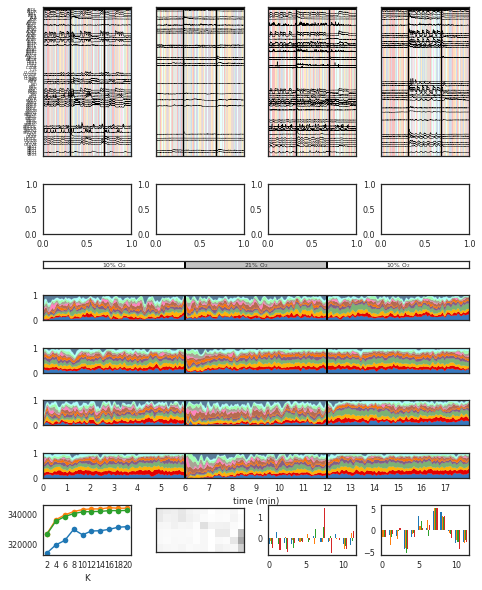

In [68]:
def make_figure_1(zs, w_to_plot, overlay=True, tmin=1, tmax=17):
    slc = slice(int(tmin*60*3), int(tmax*60*3+1))
    tslc = np.arange(int(tmin*60*3), int(tmax*60*3+1)) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(6.5, 8))
    fig.patch.set_alpha(0)
    gs = GridSpec(8, len(w_to_plot), height_ratios=[12, 4, .5, 2, 2, 2, 2, 4])

    for i, w in enumerate(w_to_plot):
        
        # Plot neural activity
        ax = fig.add_subplot(gs[0, i])
        
        if overlay:
            ax.imshow(zs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -N, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (ys[w][slc] - np.arange(N)) * ms[w][slc], '-k', lw=0.5)
        ax.plot([6, 6], [-N, 1], '-k')
        ax.plot([12, 12], [-N, 1], '-k')
        
        if i == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names, fontsize=4)
            # ax.set_ylabel("Observed $\Delta$ F/F")
        else:
            ax.set_yticks([])
        ax.set_ylim(-N,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        # ax.set_title("Worm {}".format(w+1))
#         ax.set_title(worm_names[w])

        # Plot continuous latent states
        ax = fig.add_subplot(gs[1, i])
#         zplt.plot_2d_continuous_states(xs[w], z_infs[w], xlims=(-3, 3), ylims=(-3, 3), inds=(0, 1), ax=ax)
#         ax.plot([-3, 3], [0, 0], ':k', lw=.5)
#         ax.plot([0, 0], [-3, 3], ':k', lw=.5)
#         ax.set_xlim([-3, 3])
#         ax.set_ylim([-3, 3])
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel("dim 1")
#         if i == 0:
#             ax.set_ylabel("dim 2")

    plt.subplot(gs[2, :])
    plt.imshow(us[0][None, :], aspect="auto", vmin=np.min(us[0]), vmax=2*np.max(us[0]), cmap="Greys")
    plt.text(2.5 * 60 * 3, .3, "10% O$_2$", fontsize=6)
    plt.text(8.5 * 60 * 3, .3, "21% O$_2$", fontsize=6)
    plt.text(14.5 * 60 * 3, .3, "10% O$_2$", fontsize=6)
    plt.plot([6 * 60 * 3, 6 * 60 * 3], [-.5, .5], '-k', lw=2)
    plt.plot([12 * 60 * 3, 12 * 60 * 3], [-.5, .5], '-k', lw=2)
    plt.xticks([])
    plt.yticks([])

    for g, group in enumerate(groups):
        plt.subplot(gs[3+g, :])

        # Make mountain plot
        offset = np.zeros((np.max(Ts),))
        for k in range(best_K):
            plt.fill_between(np.arange(np.max(Ts)), offset, offset + smooth_avg_usage[g, :, k], color=zplt.default_colors[k])
            offset += smooth_avg_usage[g, :, k]

        # Plot dividers
        plt.plot([6 * 60 * 3, 6 * 60 * 3], [0, 1], '-k', lw=2)
        plt.plot([12 * 60 * 3, 12 * 60 * 3], [0, 1], '-k', lw=2)

        plt.xlim(0, np.max(Ts)+1)
        if g < 3:
            plt.xticks([])
        else:
            plt.xticks(np.arange(18) * 60 * 3, np.arange(18))
            plt.xlabel("time (min)")
        plt.ylim(0, 1)
        plt.yticks([0, 1])
#         plt.ylabel(group, fontsize=6)

    # Plot the overlap
    plt.subplot(gs[7, 0])
    for transitions in transitionss:
        for observations in observationss:
            # HMM
            hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
            hmm_val_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][2] for K in Ks]
            plt.plot(Ks, hmm_val_lls, '-o', label=hmm_results_prefix)

            # HHMM
            for eta in [1e-1]:
                hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
                hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}_eta{:1.0e}".format(K, eta)][2] for K in Ks]
                plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix + " eta={:1.0e}".format(eta))

            # HHMM with inputs
            hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
            hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}_inputs".format(K)][2] for K in Ks]
            plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix + " (inputs)")

    plt.xlabel("K")
    plt.xticks(Ks)
#     plt.ylabel("Val. LL")
#     plt.legend()
    
    # Plot the overlap
    ax1 = fig.add_subplot(gs[7, 1])
    im = ax1.imshow(overlap[:, perm_overlap], vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax1.set_yticks([])
    ax1.set_xticks([])
#     ax1.set_title("state overlap")

    plt.subplot(gs[7, 2])
    for g in range(4):
        plt.bar(np.arange(irhhmm.K) + .15 * g, o2_effect[g], width=0.15)
    plt.xlim(-.15, irhhmm.K-1.5*.15)
    
    plt.subplot(gs[7, 3])
    for g in range(4):
        plt.bar(np.arange(irhhmm.K) + .15 * g, do2_on_effect[g], width=0.15)
    plt.xlim(-.15, irhhmm.K-1.5*.15)

    
    plt.tight_layout(pad=0)
    
w_to_plot = np.array([0, 11, 23, 33]) + 0
make_figure_1(z_infs, w_to_plot, overlay=True)
# make_figure_1(overlay=False)

# Second attempt

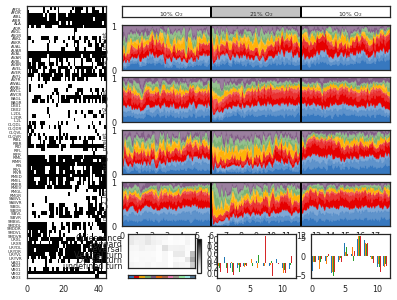

In [72]:
def make_figure_1(zs, w_to_plot, overlay=True, tmin=1, tmax=17):
    slc = slice(int(tmin*60*3), int(tmax*60*3+1))
    tslc = np.arange(int(tmin*60*3), int(tmax*60*3+1)) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(6.5, 5))
    fig.patch.set_alpha(0)
    gs = GridSpec(6, 4, height_ratios=[.5, 2, 2, 2, 2, 2])

    # Plot the observed neurons
    observed_neurons = np.column_stack([m[0] for m in ms])
    plt.subplot(gs[:, 0])
    plt.imshow(observed_neurons, cmap="Greys", vmin=0, vmax=1, extent=(0, W, N, 0), aspect="auto")
            
#     ax.plot(tslc, (ys[w][slc] - np.arange(N)) * ms[w][slc], '-k', lw=0.5)
#     ax.plot([6, 6], [-N, 1], '-k')
#     ax.plot([12, 12], [-N, 1], '-k')
        
    plt.yticks(np.arange(N) + .5, neuron_names, fontsize=4)
#     plt.ylim(0, N)
    plt.xlim(0, W)
    
    
    # Plot the oxygen level
    plt.subplot(gs[0, 1:])
    plt.imshow(us[0][None, :], aspect="auto", vmin=np.min(us[0]), vmax=2*np.max(us[0]), cmap="Greys")
    plt.text(2.5 * 60 * 3, .3, "10% O$_2$", fontsize=6)
    plt.text(8.5 * 60 * 3, .3, "21% O$_2$", fontsize=6)
    plt.text(14.5 * 60 * 3, .3, "10% O$_2$", fontsize=6)
    plt.plot([6 * 60 * 3, 6 * 60 * 3], [-.5, .5], '-k', lw=2)
    plt.plot([12 * 60 * 3, 12 * 60 * 3], [-.5, .5], '-k', lw=2)
    plt.xticks([])
    plt.yticks([])

#     for g, group in zip([0, 2, 1, 3], [groups[0], groups[2], groups[1], groups[3]]):
    for g, group in zip([0, 1, 2, 3], [groups[0], groups[1], groups[2], groups[3]]):
        plt.subplot(gs[g + 1, 1:])

        # Make mountain plot
        offset = np.zeros((np.max(Ts),))
        for k in range(best_K):
            plt.fill_between(np.arange(np.max(Ts)), offset, offset + smooth_avg_usage[g, :, k], color=new_colors[k])
            offset += smooth_avg_usage[g, :, k]

        # Plot dividers
        plt.plot([6 * 60 * 3, 6 * 60 * 3], [0, 1], '-k', lw=2)
        plt.plot([12 * 60 * 3, 12 * 60 * 3], [0, 1], '-k', lw=2)

        plt.xlim(0, np.max(Ts)+1)
        if g < 3:
            plt.xticks([])
        else:
            plt.xticks(np.arange(18) * 60 * 3, np.arange(18))
            plt.xlabel("time (min)")
        plt.ylim(0, 1)
        plt.yticks([0, 1])
        plt.ylabel(group, fontsize=6)
    
    # Plot the overlap
    ax = fig.add_subplot(gs[5, 1])
    im = ax.imshow(overlap[:, perm_overlap], vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax.set_yticks([])
    ax.set_xticks([])
    
#     divider = make_axes_locatable(ax)
#     lax = divider.append_axes("left", size="5%", pad=.1)
#     lax.imshow(np.arange(K_zimmer)[:, None], cmap=zplt.default_cmap, 
#                vmin=0, vmax=len(zplt.default_colors) - 1, aspect="auto")
#     lax.set_xticks([])
    ax.set_yticks(np.arange(K_zimmer))
    ax.set_yticklabels(z_true_key)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.1)
    plt.colorbar(im, cax=cax)
    
    divider = make_axes_locatable(ax)
    bax = divider.append_axes("bottom", size="10%", pad=.1)
    bax.imshow(np.arange(best_K)[None, :], cmap=zplt.default_cmap, 
               vmin=0, vmax=len(zplt.default_colors) - 1, aspect="auto")
    bax.set_xticks([])
    bax.set_yticks([])


#     ax1.set_title("state overlap")

    plt.subplot(gs[5, 2])
    for g in [0, 1, 2, 3]:
        plt.bar(np.arange(irhhmm.K) + .15 * g, o2_effect[g], width=0.15)
    plt.xlim(-.15, irhhmm.K)
    
    plt.subplot(gs[5, 3])
    for g in [0, 1, 2, 3]:
        plt.bar(np.arange(irhhmm.K) + .15 * g, do2_on_effect[g], width=0.15)
    plt.xlim(-.15, irhhmm.K)
    

w_to_plot = np.array([0, 11, 23, 33]) + 0
make_figure_1(z_infs, w_to_plot, overlay=True)
# make_figure_1(overlay=False)